# Downloading data from kaggle

Check out this [link](https://www.youtube.com/watch?v=yEXkEUqK52Q) to understand how to use kaggle datasets in google colab.

In [1]:
from google.colab import drive
import os
import shutil
import json

os.system("pip install kaggle")

kaggle_key_path = "/content"
dataset_path = "/content/data/"

with open(os.path.join(kaggle_key_path, "kaggle.json"), "r") as f:
    data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = data["username"]
    os.environ["KAGGLE_KEY"] = data["key"]
    del data

import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files(
    "gpiosenka/sports-classification",
    path=dataset_path,
    unzip=True
)


# Importing necessary modules

In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as image

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout, Lambda
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import mobilenet_v2

In [3]:
tf.random.set_seed(39)
np.random.seed(39)

# Loading the data

In [4]:
# Let's see what all sports are there.

sports_list = os.listdir("/content/data/train")

print(f"There are total {len(sports_list)} sports in this dataset!\n")

for i in range(0, 100, 4):
    print(f"{sports_list[i]:{20}}\t{sports_list[i+1]:{20}}\t{sports_list[i+2]:{20}}\t{sports_list[i+3]:{20}}")

There are total 100 sports in this dataset!

steer wrestling     	chuckwagon racing   	frisbee             	track bicycle       
bungee jumping      	trapeze             	nascar racing       	rock climbing       
football            	croquet             	disc golf           	rings               
shuffleboard        	ampute football     	skydiving           	roller derby        
ski jumping         	axe throwing        	surfing             	high jump           
ice yachting        	motorcycle racing   	cheerleading        	polo                
speed skating       	table tennis        	sky surfing         	parallel bar        
rollerblade racing  	bobsled             	canoe slamon        	bull riding         
horse jumping       	sidecar racing      	horseshoe pitching  	figure skating pairs
jousting            	uneven bars         	hang gliding        	sailboat racing     
water cycling       	mushing             	ice climbing        	archery             
balance beam        	rowing    

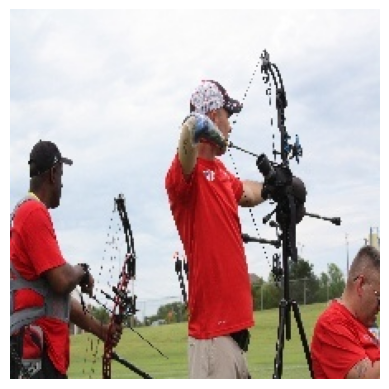

In [5]:
# Lets visualize some images

image1_path = "/content/data/train/archery/004.jpg"
image1 = image.imread(image1_path)
plt.imshow(image1)
plt.axis(False)
plt.show()

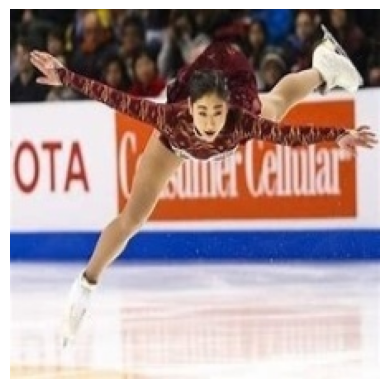

In [6]:
image2_path = "/content/data/train/figure skating women/013.jpg"
image2 = image.imread(image2_path)
plt.imshow(image2)
plt.axis(False)
plt.show()

In [7]:
# All images have the shape of (224, 224, 3)

image1.shape, image2.shape

((224, 224, 3), (224, 224, 3))

In [8]:
# Get the train, test and validation data

train_data_path = "/content/data/train"
test_data_path = "/content/data/test"
valid_data_path = "/content/data/valid"

train_data = image_dataset_from_directory(
    directory=train_data_path,
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    class_names=sports_list,
    seed=39,
    image_size=(224, 224),
    batch_size=32
)

test_data = image_dataset_from_directory(
    directory=test_data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=sports_list,
    image_size=(224, 224),
    batch_size=32
)

valid_data = image_dataset_from_directory(
    directory=valid_data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=sports_list,
    shuffle=True,
    seed=39,
    image_size=(224, 224),
    batch_size=32
)

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [9]:
train_data.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=422>

In [10]:
# np.ceil(500/32)

test_data.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=16>

In [11]:
valid_data.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=16>

In [12]:
img, lab = next(train_data.as_numpy_iterator())
print(f"Images shape is {img.shape}")
print(f"Labels shape is {lab.shape}")
print(lab)

Images shape is (32, 224, 224, 3)
Labels shape is (32, 100)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
# # Let's visualize some images from training data

# n_images = 9

# plt.figure(figsize=(12, 8))
# for i, (image, label) in enumerate(train_data.unbatch().as_numpy_iterator(), start=1):
#     plt.subplot(3, 3, i)
#     plt.imshow(image.astype("int16"))
#     plt.title(sports_list[np.argmax(label)])
#     plt.axis(False)

#     if (i == n_images):
#         break
# plt.show()

# Creating the model

### Transfer learning

 Imagine you're trying to teach a friend a new sport, say basketball. Now, if you've played basketball yourself, you already know the basics - how to shoot, dribble, pass, and defend. So, instead of teaching your friend from scratch, you can use your knowledge to help them learn faster and more efficiently.

That's essentially what transfer learning does in machine learning. It takes a model that has already learned something (let's call this the "base model") and applies it to a new but related task.

* Save Time: By using a model that has already learned something, you can skip straight to the parts that are new to the task. It's like if you already knew how to play basketball, you wouldn't have to learn the rules again when you want to play soccer.
* Use Less Data: You don't need a lot of new data to start with. You can use the knowledge from the base model to understand the new task, and then use a smaller amount of new data to refine it.
* Improve Results: Even though you have less data for the new task, the model can often perform better than if it had to learn everything from scratch. This is because the base model has already learned useful patterns that can help it understand the new task.

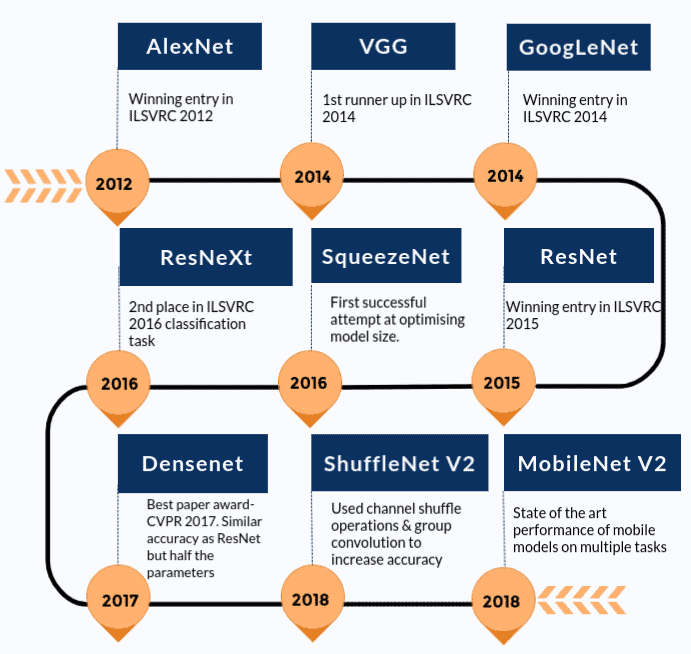

In [14]:
# Get the pre-trained model for finetuning

mobilenet = mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

for layer in mobilenet.layers:
    layer.trainable = False

# mobilenet.summary()

9406464/9406464 [==============================] - 0s 0us/step


In [15]:
# Create the model

model = Sequential([
    Input((224, 224, 3)),
    Lambda(mobilenet_v2.preprocess_input),
    mobilenet,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(512, activation="relu"),
    Dropout(0.2),
    Dense(100, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

Global average pooling

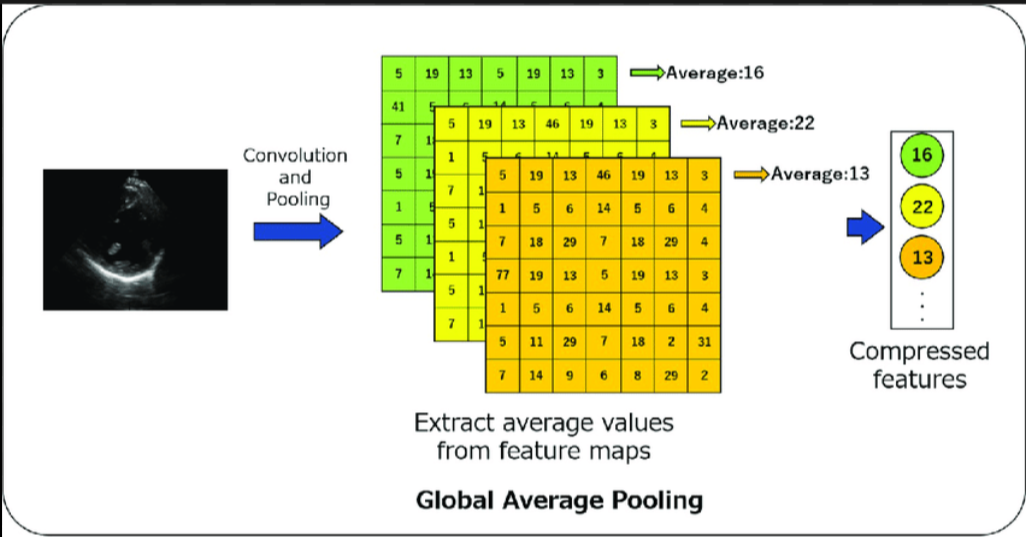

# Training the model

In [16]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.F1Score(average='macro')
    ]
)

In [17]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=valid_data,
    verbose=1
).history

Epoch 1/20
422/422 [==============================] - 38s 66ms/step - loss: 1.6761 - accuracy: 0.5709 - f1_score: 0.5699 - val_loss: 0.4533 - val_accuracy: 0.8680 - val_f1_score: 0.8653
Epoch 2/20
422/422 [==============================] - 21s 48ms/step - loss: 0.6665 - accuracy: 0.8025 - f1_score: 0.8026 - val_loss: 0.3638 - val_accuracy: 0.8820 - val_f1_score: 0.8810
Epoch 3/20
422/422 [==============================] - 20s 46ms/step - loss: 0.5070 - accuracy: 0.8449 - f1_score: 0.8451 - val_loss: 0.3159 - val_accuracy: 0.9080 - val_f1_score: 0.9081
Epoch 4/20
422/422 [==============================] - 22s 51ms/step - loss: 0.4269 - accuracy: 0.8650 - f1_score: 0.8646 - val_loss: 0.2932 - val_accuracy: 0.9080 - val_f1_score: 0.9078
Epoch 5/20
422/422 [==============================] - 21s 48ms/step - loss: 0.3681 - accuracy: 0.8846 - f1_score: 0.8847 - val_loss: 0.3367 - val_accuracy: 0.8940 - val_f1_score: 0.8914
Epoch 6/20
422/422 [==============================] - 20s 46ms/step - 

# Evaluating the model

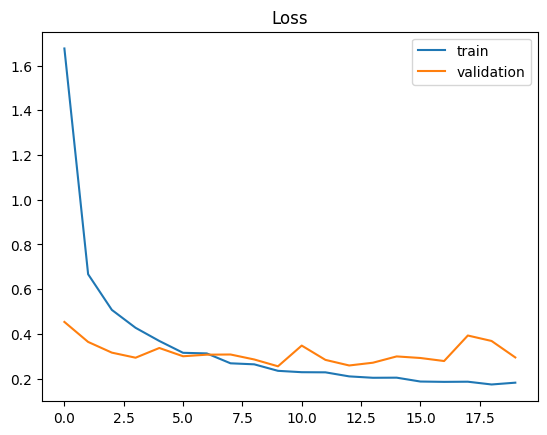

In [18]:
plt.plot(history["loss"], label="train")
plt.plot(history["val_loss"], label="validation")
plt.title("Loss")
plt.legend()
plt.show()

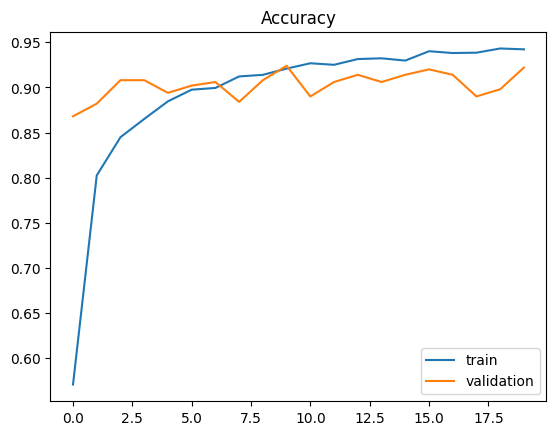

In [19]:
plt.plot(history["accuracy"], label="train")
plt.plot(history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.legend()
plt.show()

In [20]:
model.evaluate(test_data)

16/16 [==============================] - 1s 49ms/step - loss: 0.1984 - accuracy: 0.9420 - f1_score: 0.9414


[0.19835753738880157, 0.9419999718666077, 0.9413989782333374]

In [21]:
y_true = []
test_images = []
for image, label in test_data.unbatch().as_numpy_iterator():
    y_true.append(np.argmax(label))
    test_images.append(image.tolist())

y_pred = model.predict(np.array(test_images))

16/16 [==============================] - 1s 43ms/step


In [22]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([81, 89, 44, 11, 69, 31, 89, 68, 56, 18, 56, 84, 46, 64, 82, 83, 78,
       60, 13,  4, 86,  0, 38, 14, 72, 22, 31, 65, 60, 60, 75, 18, 18, 69,
       61, 19, 14,  0, 38,  8, 65, 18, 10, 44, 88, 42, 14, 84, 15, 49, 91,
       73, 98, 58, 80, 90, 47, 93, 83, 73, 54, 92,  7, 82, 53, 76, 70, 26,
       32, 95, 87, 34, 62, 12, 41, 31, 95, 69, 39, 57, 61, 73, 39, 22, 55,
       23, 82, 76,  2, 35,  4, 72, 16, 93, 74, 74, 97, 30, 19, 71, 64, 25,
       78, 24, 14, 33, 61, 26, 47, 20, 57, 92, 75,  7, 35, 24, 17, 39, 93,
       51, 38, 73, 89, 48, 66, 99, 91,  1, 51, 56, 51, 53, 91, 95, 19, 60,
       23, 15, 70, 43, 68, 64, 71, 71, 30, 24, 84, 86, 87, 54, 27, 68, 46,
       97, 40,  9, 24, 52, 57, 59, 86, 76, 48, 44, 22, 96,  6, 59, 69, 36,
       57, 67, 45, 49, 71, 22, 17, 73, 28, 98, 78, 65, 78, 54, 41, 47, 83,
       11, 52, 30,  2,  3, 63, 79, 96, 61, 49, 20, 31, 44, 85, 44, 50, 27,
       25, 87, 91, 52, 86, 67, 63, 15, 77, 81, 68, 41, 21, 62, 72, 16, 66,
       74, 29, 37, 79, 36

In [23]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

print(f"The accuracy is {accuracy_score(y_true, y_pred)}")
print("The f1 score is ", f1_score(y_true, y_pred, average="macro"))

The accuracy is 0.942
The f1 score is  0.9413989898989898


In [24]:
print("Classification report")
print(classification_report(y_true, y_pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       0.80      0.80      0.80         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5
           5       0.71      1.00      0.83         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       0.80      0.80      0.80         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       0.83      1.00      0.91         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
     

Confusion matrix


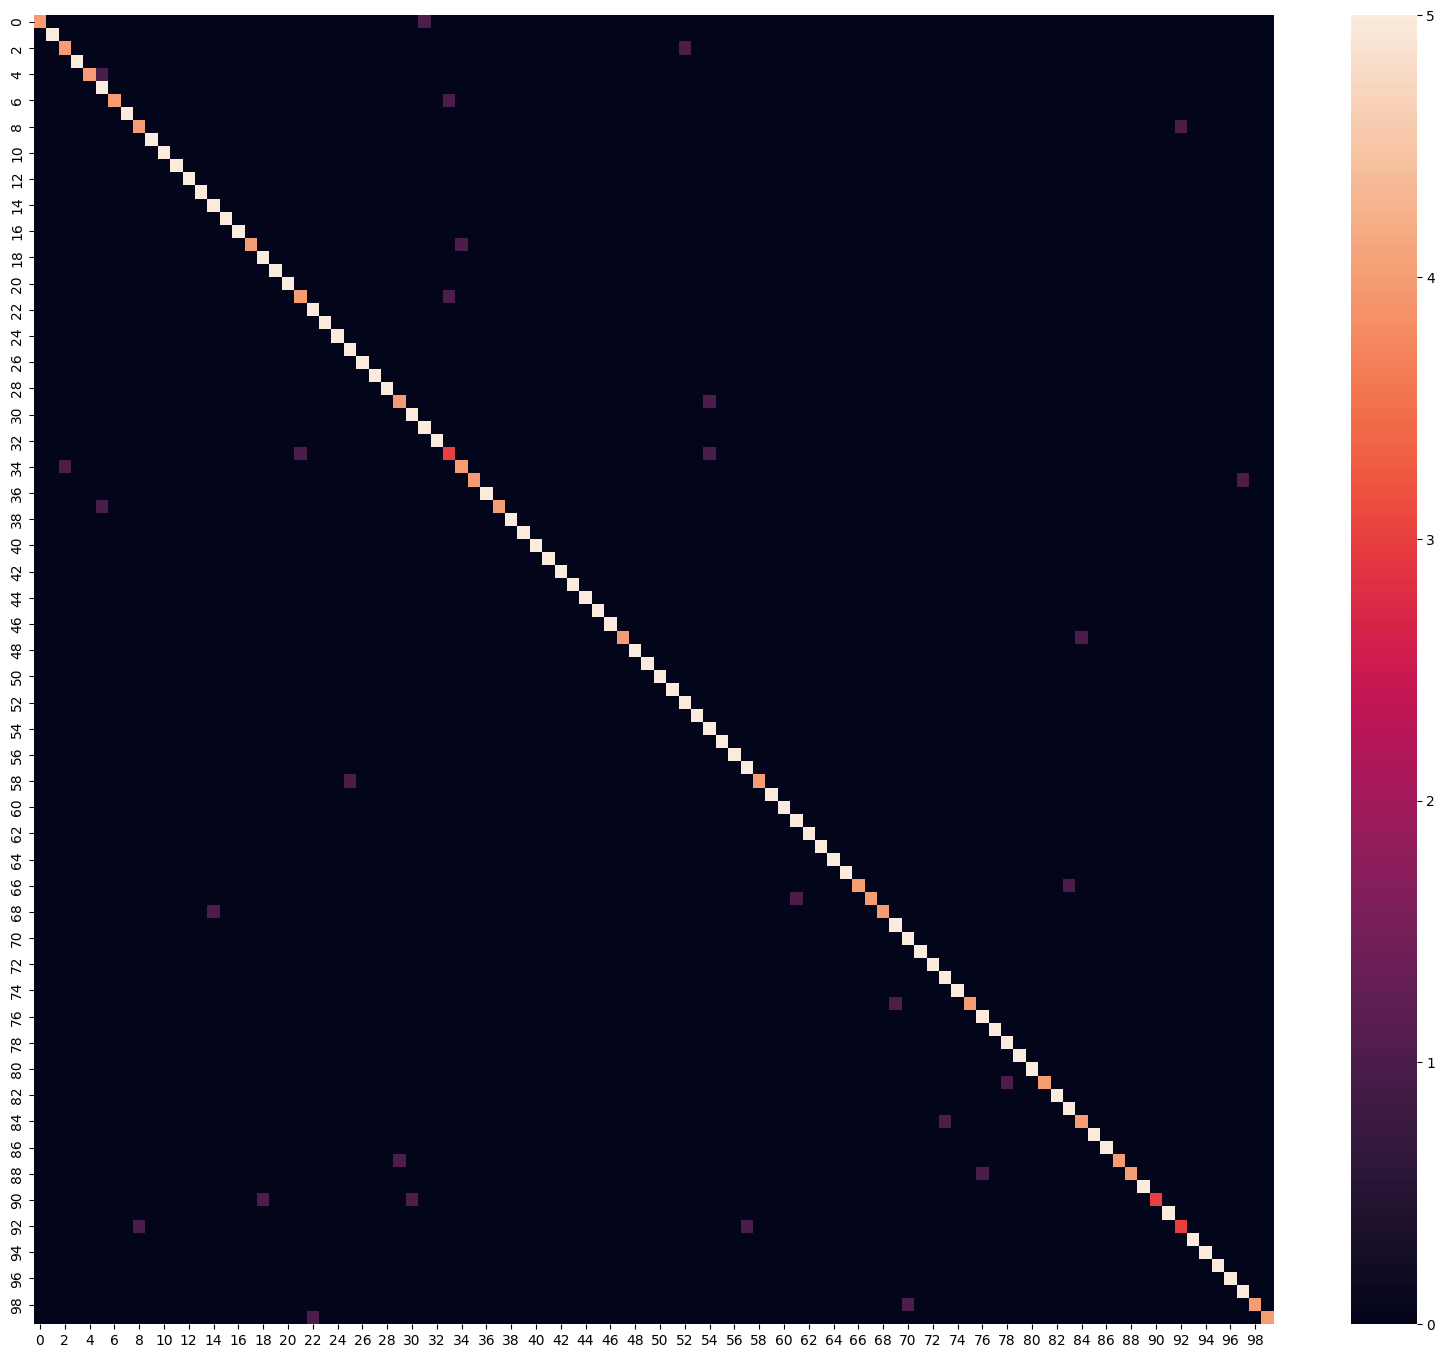

In [25]:
print("Confusion matrix")
conf_matrix = confusion_matrix(y_true, y_pred)

import seaborn as sns

plt.figure(figsize=(20, 17))
sns.heatmap(conf_matrix)
plt.show()

1/1 [==============================] - 2s 2s/step


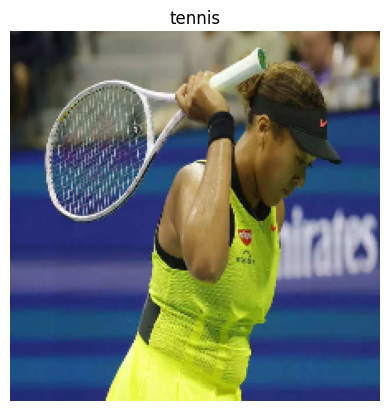

In [26]:
import urllib.request

url = 'https://img.etimg.com/thumb/width-640,height-480,imgsize-78314,resizemode-75,msid-85943078/news/sports/why-does-playing-tennis-make-so-many-pros-miserable/osaka-reuters.jpg'

urllib.request.urlretrieve(url, 'image.jpg')

img = cv2.imread('image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))

prediction = model.predict(np.expand_dims(img, 0))

plt.imshow(img)
plt.axis(False)
plt.title(sports_list[np.argmax(prediction)])
plt.show()